
### This notebook describes how you can use non-text features when training BERT for a scpecific task. Also in the notebook there is a description of how to use regularization on a specific network layer. I will show this using an open "nlp-getting-started" competition as an example.

Content:
* Loading data
* Preprocess data
* Building custom DataLoader
* Building Network
* Training and validation
* Predicting test data

# Loading data
You cat find data in this competition https://www.kaggle.com/c/nlp-getting-started

In [ ]:
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [ ]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train.sample(5)

# Preprocessing
## Let's create a simple preprocessor for our text data.

In [ ]:
def preprocess(text):
    text = text.lower()
    # links
    text = re.sub(r'http\S+', 'link', text)
    text = re.sub(r'www\S+', 'link', text)
    # mails
    text = re.sub(r'\S*@\S*\s?', '', text)
    # abbreviations
    text = text.replace(r'&amp;?', r'and')
    text = text.replace(r'&lt;', r'<')
    text = text.replace(r'&gt;', r'>')
    # non ascii symbols
    text = text.encode("ascii", errors="ignore").decode()
    # safe only latters, numbers and punktuations
    text = re.sub(r'[^a-zA-Z0-9!?. ]', ' ', text)
    # duplicated punkt
    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    # several spaces
    text = re.sub(r'\s+', ' ', text)
    return text

print(preprocess('&gt;&gt; $15 Aftershock : Protect Yourself and Profit in the    Next Global Financial... ##book http://t.co/f6ntUc734Z\n@esquireattire'))

In [ ]:
train['text'] = train['text'].apply(preprocess)

## Selecting non-text features. In our case it will be categorical features named keyword
We will use the top 50 popular keywords in each class as signs.

In [ ]:
disast_top_keywords = list(train[train['target'] == 1]['keyword'].value_counts()[:50].index)
non_disast_top_keywords = list(train[train['target'] == 0]['keyword'].value_counts()[:50].index)
top_keywords = [disast_top_keywords + non_disast_top_keywords]

# Building custom DataLoader
## Let's create data loader which we will put into the our future model.
As a BERT architecture we will use DistilBERT.

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import BertTokenizer, BertModel

In [ ]:
class DataLoader:
    """Texts and non-text features are putted to the input,
    at the output we get data that can be loaded into the our neural network"""
    def __init__(self, dataframe, tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased'), 
                 cat_features=[], batch_size=1, categories='auto', shuffle=True):
        
        self.shuffle = shuffle
        self.dataframe = dataframe
        self.cat_features = cat_features
        self.size = self.dataframe.shape[0]
        self.batch_size = batch_size
        
        categories = [np.array(column_cats) for column_cats in categories]
        self.cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, categories=categories)
        self.cat_encoder.fit(self.dataframe[cat_features])
        
        self.tokenizer = tokenizer
        
    def get_cat_features_dim(self):
        return self.cat_encoder.get_feature_names().shape[0]
    
    def __iter__(self):
        self.idx = 0
        if self.shuffle:
            self.dataframe = self.dataframe.sample(self.size).reset_index(drop=True)
        return self
        
    def __next__(self):
        if self.idx < self.size:
            bounds = (self.idx, self.idx + self.batch_size)
            dataframe_batch = self.dataframe.iloc[bounds[0]: bounds[1]]
            
            # Transforming categorical features into an one hot vector
            encoded_features = self.cat_encoder.transform(dataframe_batch[self.cat_features])
            
            text = dataframe_batch['text'].tolist()
            # Tokenizing text features
            encoded_text = self.tokenizer(text, return_tensors='pt', padding=True)
            # For python >= 3.9:
            # inp_batch = {'nontext_features': torch.FloatTensor(encoded_features)} | encoded_text
            inp_batch = {'nontext_features': torch.FloatTensor(encoded_features), **encoded_text}
            target_batch = torch.FloatTensor(dataframe_batch['target'].tolist())
            
            self.idx = bounds[1]
            
            return inp_batch, target_batch
        else:
            raise StopIteration

# Simple example of DataLoder work:
# loader = DataLoader(train, cat_features=['keyword'], batch_size=2, categories=top_keywords)
# print(next(iter(loader)))

# Building network
## Main part of notebook. Now let's build the model.

`Scheme of ConcatModel`

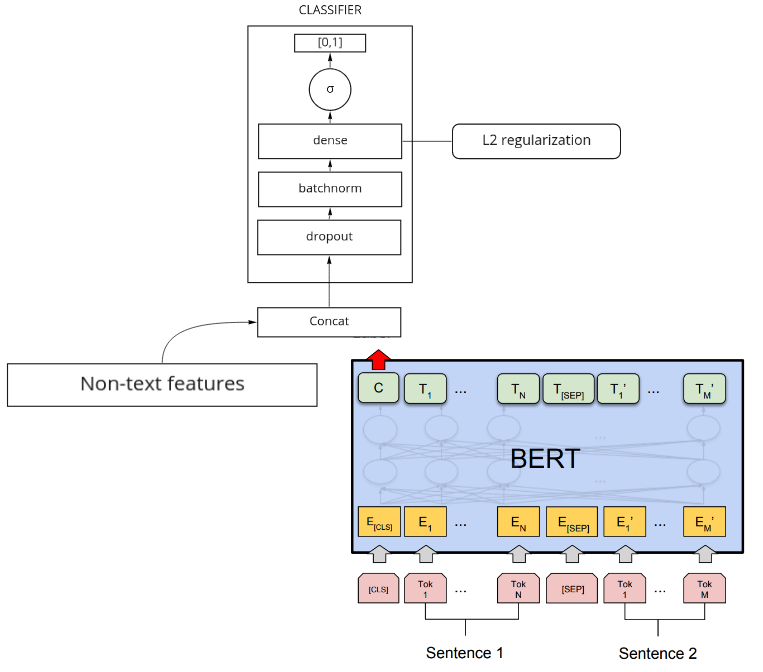

`PyTorch implementation`

But l2 regularization will be added later when we calculate the loss

In [ ]:
class ConcatModel(nn.Module):
    def __init__(self, nontext_features_dim,
                 bert_model=DistilBertModel.from_pretrained("distilbert-base-uncased")):
        super().__init__()
        self.bert = bert_model
        
        bert_embedding_dim = self.bert.embeddings.word_embeddings.embedding_dim
        dense_input_dim = nontext_features_dim + bert_embedding_dim
        
        # In my case I'll use this layers for classification.
        # But you can modify it for your task as you want.
        self.dropout = nn.Dropout(p=0.1)
        self.batch_norm = torch.nn.LayerNorm(dense_input_dim)
        self.dense = nn.Linear(dense_input_dim, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, nontext_features, **kwargs):
        # Getting the output of [CLS] token of the BERT.
        cls_output = self.bert.forward(**kwargs)[0][:, 0]
        
        # nontext_feautes shape: [batch_size, nontext_features_dim]
        # Concatenation of text and non-text features
        x = torch.cat((nontext_features, cls_output), 1)
        
        x = self.dropout(x)
        x = self.batch_norm(x)
        x = self.dense(x)
        x = self.activation(x)
        x = x.flatten()
        
        return x

# Simple example of ConcatLoader output
# model = ConcatModel(loader.get_cat_features_dim())
# print(model(**next(iter(loader))[0]))

# Training and validation

In [ ]:
from datetime import datetime

from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

Initialize train and test loaders

In [ ]:
BATCH_SIZE = 320

trainset, testset = train_test_split(train, test_size=0.2)

train_loader = DataLoader(trainset, cat_features=['keyword'], batch_size=BATCH_SIZE, 
                                     categories=top_keywords)
test_loader = DataLoader(testset, cat_features=['keyword'], batch_size=BATCH_SIZE, 
                                    categories=top_keywords, shuffle=False)

Initialize model, loss function(criterion) and optimizer

In [ ]:
cat_features_dim = train_loader.get_cat_features_dim()

model = ConcatModel(cat_features_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5)

Select device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# auxiliary function for transferring the contents of the dictionary to the device.
def dict_to_device(dict_, device):
    device_dict = {}
    for key in dict_:
        if isinstance(dict_[key], torch.Tensor):
            device_dict[key] = dict_[key].to(device)
        else:
            device_dict[key] = dict_[key]
    return device_dict

## Training and validation

In [ ]:
history = []
rolling_history = []

train_f1 = []
valid_f1 = []

epochs = 6

model.to(device)

time_start = datetime.now()
for i in range(epochs):
    # train epoch
    model.train()
    
    train_preds = []
    train_targets = []
    for j, (inp, target) in enumerate(train_loader):
        optimizer.zero_grad()

        inp = dict_to_device(inp, device)
        target = target.to(device)
        output = model(**inp)

        loss = criterion(output, target)
        
        # Calculate l2 norm of last dense layer.
        l2_norm = 0.1 * (torch.norm(model.dense.weight, p=2) +
                         torch.norm(model.dense.bias, p=2)).to(device)
        # Add this to the loss. So we do the regularization of the last layer of the network.
        loss += l2_norm
        
        loss.backward()
        optimizer.step()
        
        train_preds.extend(output.detach().cpu().tolist())
        train_targets.extend(target.detach().cpu().tolist())
        
        history.append(loss.item())
        # Online plotting rolling average train loss, train and test F1 score.
        if j%10 == 0 and j > 0:

            rolling_history.append(
                sum(history[-10: ]) / 10
            )
            clear_output(wait=True)
            
            fig, ax = plt.subplots(ncols=3, figsize=(20,5))
            
            ax[0].plot(rolling_history)
            ax[0].set_title('Training loss')

            ax[1].plot(train_f1)
            ax[1].set_title('Train f1')
            
            ax[2].plot(valid_f1)
            ax[2].set_title('Validation f1')
            
            plt.show()
        
    # validation:
    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        # Calculate F1 score on test
        for inp, target in test_loader:
            inp = dict_to_device(inp, device)
            output = model(**inp)
            pred = [int(ans > 0.5) for ans in output.cpu().tolist()]
            y_pred.extend(pred)
            y_true.extend(target.tolist())
            
        valid_f1.append(f1_score(y_pred, y_true))
        
        # Calculate F1 score on train
        train_preds = [int(ans > 0.5) for ans in train_preds]
        train_f1.append(f1_score(train_preds, train_targets))
        
time_end = datetime.now()
delta_time = time_end - time_start
print(delta_time.seconds, 'seconds')

# Predict test data
## Training on whole dataset and predict test samples

In [ ]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test['target'] = 0
test['text'] = test['text'].apply(preprocess)

In [ ]:
BATCH_SIZE = 320

train_loader = DataLoader(train, cat_features=['keyword'], batch_size=BATCH_SIZE, 
                                     categories=top_keywords)
test_loader = DataLoader(test, cat_features=['keyword'], batch_size=BATCH_SIZE, 
                                    categories=top_keywords, shuffle=False)

In [ ]:
cat_features_dim = train_loader.get_cat_features_dim()

model = ConcatModel(cat_features_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

epochs = 5
for i in range(epochs):
    train_preds = []
    train_targets = []
    for j, (inp, target) in enumerate(train_loader):
        optimizer.zero_grad()

        inp = dict_to_device(inp, device)
        target = target.to(device)
        output = model(**inp)

        loss = criterion(output, target)
        l2_norm = 0.1 * (torch.norm(model.dense.weight, p=2) +
                         torch.norm(model.dense.bias, p=2)).to(device)
        loss += l2_norm
        
        loss.backward()
        optimizer.step()

In [ ]:
y_pred = []
model.eval()
with torch.no_grad():
    for inp, _ in test_loader:
        inp = dict_to_device(inp, device)
        output = model(**inp)
        pred = [int(ans > 0.5) for ans in output.cpu().tolist()]
        y_pred.extend(pred)
        
test['target'] = y_pred
test[['id', 'target']].to_csv('submission.csv', index=False)